In [1]:
import torch
import sys
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
sys.path.append('../')
from models.network import *
from models.utils import *

In [2]:
config = '-max_background_compactions=13 -max_background_flushes=1 -write_buffer_size=2003968 -max_write_buffer_number=8 -min_write_buffer_number_to_merge=2 -compaction_pri=3 -compaction_style=0 -level0_file_num_compaction_trigger=8 -level0_slowdown_writes_trigger=31 -level0_stop_writes_trigger=48 -compression_type=lz4 -bloom_locality=0 -open_files=100000 -block_size=2048 -cache_index_and_filter_blocks=0 -max_bytes_for_level_base=5242880 -max_bytes_for_level_multiplier=8 -target_file_size_base=1394688 -target_file_size_multiplier=2 -num_levels=7 -memtable_bloom_size_ratio=0 -compression_ratio=0'
compression_type = {'snappy':0, 'zlib':1, 'lz4':2, 'none':3}
splt_config = config.split(' ')
column = []
data = []
# for cfg in splt_config:
#     c, v = cfg.split('=')
#     if c == '-compression_type':
#         conf.append(compression_type[v])
#     else:
#         conf.append(int(v))
#     break
for cfg in splt_config:
    c, v = cfg.split('=')
    column.append(c[1:])
    if c == '-compression_type':
        data.append(compression_type[v])
    else:
        data.append(int(v))

In [3]:
config = pd.DataFrame(data=data, index=column).T
config

,max_background_compactions,max_background_flushes,write_buffer_size,max_write_buffer_number,min_write_buffer_number_to_merge,compaction_pri,compaction_style,level0_file_num_compaction_trigger,level0_slowdown_writes_trigger,level0_stop_writes_trigger,...,open_files,block_size,cache_index_and_filter_blocks,max_bytes_for_level_base,max_bytes_for_level_multiplier,target_file_size_base,target_file_size_multiplier,num_levels,memtable_bloom_size_ratio,compression_ratio
0,13,1,2003968,8,2,3,0,8,31,48,...,100000,2048,0,5242880,8,1394688,2,7,0,0


In [4]:
target = 17
hidden_size = 128
tf = False
batch_size = 32
similar_wk = 6

In [5]:
KNOB_PATH = '../data/rocksdb_conf'
EXTERNAL_PATH = '../data/external'
INTERNAL_PATH = '../data/internal'
WK_NUM = 16

raw_knobs = rocksdb_knobs_make_dict(KNOB_PATH)
raw_knobs = pd.DataFrame(data=raw_knobs['data'].astype(np.float32), columns=raw_knobs['columnlabels'])

internal_dict = {}
external_dict = {}

pruned_im = pd.read_csv(os.path.join(INTERNAL_PATH, 'internal_ensemble_pruned_tmp.csv'), index_col=0)
for wk in range(WK_NUM):
    im = pd.read_csv(os.path.join(INTERNAL_PATH, f'internal_results_{wk}.csv'), index_col=0)
    internal_dict[wk] = im[pruned_im.columns]
if target > 15:
    im = pd.read_csv(f'../data/target_workload/{target}/internal_results_11.csv', index_col=0)
    internal_dict[wk+1] = im[pruned_im.columns]

for wk in range(WK_NUM):
    ex = pd.read_csv(os.path.join(EXTERNAL_PATH, f'external_results_{wk}.csv'), index_col=0)
    external_dict[wk] = ex
if target > 15:
    ex = pd.read_csv(f'../data/target_workload/{target}/external_results_11.csv', index_col=0)
    external_dict[wk+1] = ex

In [6]:
em_tr, em_te = train_test_split(external_dict[similar_wk], test_size=0.2, random_state=22)
scaler_em = StandardScaler().fit(em_tr)

In [7]:
def get_index_value(raw_knobs):
    index_value = dict()
    for col in raw_knobs.columns:
        iv = raw_knobs[[col]].value_counts()#.reset_index(level=0).drop(columns=0)
        iv = iv.sort_index()
        index_value[col] = pd.Series(data=range(len(iv)), index=iv.index)
    return index_value

In [8]:
def make_knobsOneHot(index_value, k, raw_knobs):
        knobs_one_hot = torch.Tensor()
        for i in range(len(k)):   
            sample = torch.Tensor()
            for col in raw_knobs.columns:
                knob_one_hot = torch.zeros(len(index_value[col]))
                knob_one_hot[index_value[col][k[col][i]]] = 1
                sample = torch.cat((sample, knob_one_hot))
            sample = sample.unsqueeze(0)
            knobs_one_hot = torch.cat((knobs_one_hot, sample))
        return np.array(knobs_one_hot)

In [9]:
def get_knob2vec(data, table):
    k2vec = np.zeros((data.shape[0], 22, table.shape[1]))
    for i in range(data.shape[0]):
#         idx = (data[i]==1).nonzero().squeeze().cpu().detach().numpy()
        idx = (data[i]==1).nonzero().squeeze().cpu().detach().numpy()
        k2vec[i] = table[idx]
    return k2vec

In [10]:
index_value = get_index_value(raw_knobs)
conf_one_hot = make_knobsOneHot(index_value, config, raw_knobs)
table = np.load(f'../data/lookuptable/{similar_wk}/LookupTable.npy')
conf_knob2vec = get_knob2vec(torch.Tensor(conf_one_hot), table)
conf_knob2vec = torch.Tensor(conf_knob2vec).cuda()

/home/jieun/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  """


In [11]:
encoder = EncoderRNN(input_dim=1024, hidden_dim=hidden_size)
decoder = AttnDecoderRNN(input_dim=1, hidden_dim=hidden_size, output_dim=1)
model = GRUNet(encoder=encoder, decoder=decoder, tf=tf, batch_size=batch_size).cuda()

In [12]:
model = torch.load('../model_save/20210923/model-20210923-05.pt')

In [13]:
model.tf = False
model.batch_size = 1

In [14]:
conf_knob2vec.shape

torch.Size([1, 22, 1024])

In [15]:
output, attn_w = model(conf_knob2vec)

In [16]:
np.round(scaler_em.inverse_transform(output.cpu().detach().numpy()),2 )

array([[ 3.39, 99.49,  5.94, 24.18]], dtype=float32)

In [20]:
attn_w = attn_w.squeeze()
attn_w = attn_w.cpu().detach().numpy()

In [44]:
import matplotlib.ticker as ticker

In [75]:
external_dict[0].columns

Index(['TIME', 'RATE', 'WAF', 'SA'], dtype='object')

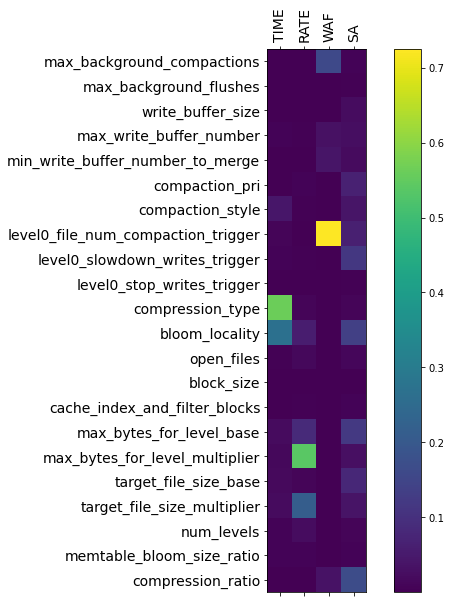

In [77]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()

im = ax.matshow(attn_w, interpolation='none')
fig.colorbar(im)

fontdict = {'fontsize': 14}

ax.set_xticks(np.arange(4))
ax.set_xticklabels(external_dict[0].columns, fontdict=fontdict, rotation=90)
ax.set_yticks(np.arange(22))
ax.set_yticklabels(raw_knobs.columns, fontdict=fontdict)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()